<a href="https://colab.research.google.com/github/pscabral/Prezunic/blob/main/%20InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 385858, done.
remote: Counting objects: 100% (8693/8693), done.
remote: Compressing objects: 100% (8659/8659), done.
remote: Total 385858 (delta 37), reused 8688 (delta 34), pack-reused 377165
Receiving objects: 100% (385858/385858), 2.10 GiB | 21.58 MiB/s, done.
Resolving deltas: 100% (1197/1197), done.
Updating files: 100% (90503/90503), done.


In [2]:
import os

# Diretório raiz
root_directory = '/content/Fruit-Images-Dataset/Validation'

# Lista de subpastas
subfolders = [
    'apple_6',
    'apple_braeburn_1',
    'apple_crimson_snow_1',
    'apple_golden_1',
    'apple_golden_2',
    'apple_golden_3',
    'apple_granny_smith_1',
    'apple_hit_1',
    'apple_pink_lady_1',
    'apple_red_1',
    'apple_red_2',
    'apple_red_3',
    'apple_red_delicious_1',
    'apple_red_yellow_1',
    'apple_rotten_1',
    'cabbage_white_1',
    'carrot_1',
    'cucumber_1',
    'cucumber_3',
    'eggplant_violet_1',
    'pear_1',
    'pear_3',
    'zucchini_1',
    'zucchini_dark_1'
]

# Crie a estrutura de pastas
for folder in subfolders:
    folder_path = os.path.join(root_directory, folder)
    os.makedirs(folder_path, exist_ok=True)

In [1]:
# Imports: Importa as bibliotecas e módulos necessários para construir o modelo de rede neural
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle  # Importa a biblioteca pickle para manipulação de dados em formato binário
import numpy as np  # Importa a biblioteca NumPy para operações matriciais
import matplotlib.pyplot as plt  # Importa a biblioteca Matplotlib para plotagem de gráficos

import warnings
warnings.filterwarnings("ignore")  # Suprime avisos (warnings)

In [2]:
# Caminho Base para todos os arquivos
data_dir = '../content/Fruit-Images-Dataset'

In [3]:
# Preparando os Dados
# Usando o ImageDataGenerator para carregar as imagens para treinamento e teste do modelo de CNN

datagenerator = {
    "train": ImageDataGenerator(
        horizontal_flip=True,  # Realiza inversão horizontal aleatória nas imagens
        vertical_flip=True,    # Realiza inversão vertical aleatória nas imagens
        rescale=1. / 255,     # Normaliza os valores dos pixels das imagens para o intervalo [0, 1]
        validation_split=0.1,  # Define uma divisão de validação de 10% dos dados de treinamento
        shear_range=0.1,      # Aplica cisalhamento aleatório nas imagens
        zoom_range=0.1,       # Aplica zoom aleatório nas imagens
        width_shift_range=0.1,  # Realiza deslocamento aleatório na largura das imagens
        height_shift_range=0.1, # Realiza deslocamento aleatório na altura das imagens
        rotation_range=30,     # Realiza rotação aleatória das imagens em até 30 graus
    ).flow_from_directory(
        directory=data_dir + "/Training",  # Diretório de treinamento
        target_size=(300, 300),  # Redimensiona as imagens para o tamanho alvo de (300, 300) pixels
        subset='training',       # Subconjunto de treinamento
    ),

    "valid": ImageDataGenerator(
        rescale=1 / 255,         # Normaliza os valores dos pixels das imagens para o intervalo [0, 1]
        validation_split=0.1,    # Define uma divisão de validação de 10% dos dados de teste
    ).flow_from_directory(
        directory=data_dir + "/Test",  # Diretório de teste
        target_size=(300, 300),      # Redimensiona as imagens para o tamanho alvo de (300, 300) pixels
        subset='validation',         # Subconjunto de validação
    ),
}

Found 60955 images belonging to 131 classes.
Found 2209 images belonging to 131 classes.


In [4]:
# Inicializando o Modelo Base
# Inicializa o modelo InceptionV3 (pré-treinado) com a forma de imagem de entrada como (300, 300, 3)
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))

# Carregando Pesos para o Modelo InceptionV3
base_model.load_weights("../content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")

# Configurando o Treinamento de todas as camadas do modelo InceptionV3 como falso
base_model.trainable = False

In [5]:
# Adicionando Camadas ao Final do Modelo
# Adicionando algumas camadas extras ao final do modelo de acordo com nossos requisitos
model = Sequential([
    base_model,  # Modelo InceptionV3 definido anteriormente
    GlobalAveragePooling2D(),  # Camada de Global Average Pooling
    Dropout(0.15),  # Camada de Dropout com uma taxa de 0.15 (15% de neurônios desativados aleatoriamente)
    Dense(1024, activation='relu'),  # Camada densa com 1024 unidades e ativação ReLU
    Dense(131, activation='softmax')  # Camada densa com 131 unidades e ativação softmax (6 neurônios de saída para 6 classes)
])

In [6]:
# Otimizador Adam
# Utilizando o Otimizador Adam para definir a taxa de aprendizado do nosso modelo final
opt = optimizers.Adam(learning_rate=0.0001)  # Definindo uma taxa de aprendizado de 0.0001

# Compilação e definição dos parâmetros que desejamos que nosso modelo utilize
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [ ]:
# Visualizando o resumo do modelo
model.summary()

In [8]:
# Separando Dados de Treinamento e Teste
# Definindo variáveis para o modelo
batch_size = 512  # Tamanho do lote (batch size) utilizado durante o treinamento
epochs = 1  # Número de épocas (ciclos de treinamento)

# Separando os Dados de Treinamento e Teste
train_generator = datagenerator["train"]  # Gerador de dados de treinamento
valid_generator = datagenerator["valid"]  # Gerador de dados de validação

In [9]:
# Cálculo de variáveis para o modelo
steps_per_epoch = train_generator.n // batch_size  # Número de passos por época de treinamento
validation_steps = valid_generator.n // batch_size  # Número de passos por época de validação

# Exibindo informações sobre os passos por época
print("steps_per_epoch:", steps_per_epoch)  # Exibe o número de passos por época de treinamento
print("validation_steps:", validation_steps)  # Exibe o número de passos por época de validação

steps_per_epoch: 119
validation_steps: 4


In [10]:
# Utilizando o ModelCheckpoint
# Caminho do arquivo para armazenar os modelos treinados
filepath = "./CNN-Models/model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Usando a função ModelCheckpoint para treinar e armazenar todos os melhores modelos
checkpoint1 = ModelCheckpoint(
    filepath,            # Caminho do arquivo para salvar o modelo
    monitor='val_accuracy',  # Monitora a métrica de acurácia na validação
    verbose=1,           # Exibe informações durante o treinamento
    save_best_only=True,  # Salva apenas o melhor modelo com base na métrica monitorada
    mode='max'           # Modo de otimização para a métrica (maximizar a acurácia)
)

callbacks_list = [checkpoint1]  # Lista de callbacks utilizados durante o treinamento

In [11]:
# Treinando o Modelo
history = model.fit_generator(
    generator=train_generator,  # Gerador de dados de treinamento
    epochs=epochs,             # Número de épocas de treinamento
    steps_per_epoch=steps_per_epoch,  # Número de passos por época de treinamento
    validation_data=valid_generator,  # Dados de validação
    validation_steps=validation_steps,  # Número de passos por época de validação
    callbacks=callbacks_list  # Lista de callbacks a serem utilizados durante o treinamento
)

119/119 [==============================] - ETA: 0s - loss: 4.2302 - accuracy: 0.1610
Epoch 1: val_accuracy improved from -inf to 0.39062, saving model to ./CNN-Models/model_01-0.39.h5
119/119 [==============================] - 1024s 9s/step - loss: 4.2302 - accuracy: 0.1610 - val_loss: 3.2558 - val_accuracy: 0.3906


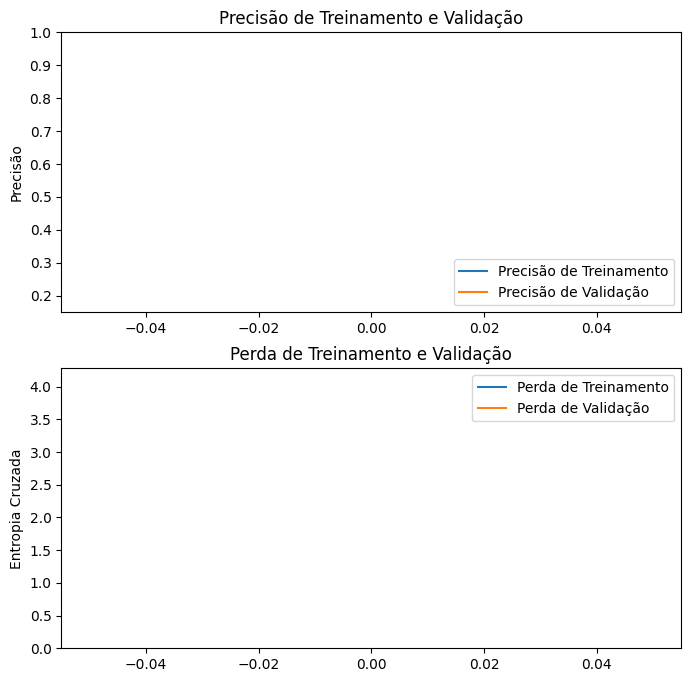

In [12]:
# Plotando as métricas finais de treinamento
acc = history.history['accuracy']  # Precisão de treinamento
val_acc = history.history['val_accuracy']  # Precisão de validação

loss = history.history['loss']  # Perda de treinamento
val_loss = history.history['val_loss']  # Perda de validação

# ________________ Gráfico 1 -------------------------
# Gráfico de Precisão

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Precisão de Treinamento')
plt.plot(val_acc, label='Precisão de Validação')
plt.legend(loc='lower right')
plt.ylabel('Precisão')
plt.ylim([min(plt.ylim()), 1])
plt.title('Precisão de Treinamento e Validação')

# ________________ Gráfico 2 -------------------------
# Gráfico de Perda

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda de Treinamento')
plt.plot(val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.ylabel('Entropia Cruzada')
plt.ylim([0, max(plt.ylim())])
plt.title('Perda de Treinamento e Validação')
plt.show()

In [13]:
# Testando o modelo final
# Calcula a Perda e Precisão nos Dados de Validação
test_loss, test_acc = model.evaluate(valid_generator)  # Avalia o modelo nos dados de validação
print('precisão nos testes : ', test_acc)  # Exibe a precisão nos testes

70/70 [==============================] - 509s 7s/step - loss: 3.3932 - accuracy: 0.3708
precisão nos testes :  0.37075600028038025
